## Electron density visualisation

In [95]:
# import packages
import pyscf
import numpy as np

In [96]:
# create molecule and run RHF calculation
mol = pyscf.gto.Mole()
mol.build(
    atom = """H -0.36 0 0; H 0.36 0 0""", # default distance unit is angstrom
    basis = "6-31g",
    symmetry="C1"
)
mf = pyscf.scf.RHF(mol) # init HF object
mf.kernel() # run SCF

converged SCF energy = -1.12675331969834


-1.1267533196983448

The first-order electron density operator $\hat{\rho}(\mathbf{r})$ is defined in first quantisation as
$$
\hat{\rho}(\mathbf{r}) = \sum_{i}^N \delta(\mathbf{r_i} - \mathbf{r}).
$$

We define the Hartree-Fock Slater determinant $\ket{\Phi} = |\phi_1 \phi_2 ... \phi_N|$ as 
$$
 \prod_i a_i^\dag \ket{0},
 $$
such that we can define the density operator in second quantisation (cf. Helgaker CH1) as
$$\hat{\rho}(\mathbf{r}) = \sum_{pq}^K \rho(\mathbf{r})_{pq} a_p^\dag a_q$$
with
$$
\rho(\mathbf{r})_{pq} = \int d\mathbf{r}' \phi_p^*(\mathbf{r}') \delta(\mathbf{r}' - \mathbf{r}) \phi_q(\mathbf{r}') =
 \phi_p^*(\mathbf{r})\phi_q(\mathbf{r})
 $$

This gives us the first-order electron density
$$
 \bra{\Phi}\hat{\rho}(\mathbf{r})\ket{\Phi} = \sum_{pq}^K \phi_p^*(\mathbf{r})\phi_q(\mathbf{r}) \bra{\Phi}a_p^\dag a_q\ket{\Phi} = 
\sum_{pq}^K \phi_p^*(\mathbf{r})\phi_q(\mathbf{r}) \gamma_{pq} = \sum_i^{N_{occ}} \phi_i^*(\mathbf{r})\phi_i(\mathbf{r}).
$$
Expanding the MOs in a basis of atomic orbitals $\chi$
$$
\ket{\phi_p} = \sum_\mu C_{\mu i} \ket{\chi_\mu}
$$
and defining the first order density matrix (1-RDM)
$$
D_{\mu\nu} = \sum_i^{N_{occ}} C_{\mu i} C_{\nu i}^*
$$
we find
$$
\bra{\Phi}\hat{\rho}(\mathbf{r})\ket{\Phi} = \sum_{\mu \nu} D_{\nu\mu} \chi_\mu^*(\mathbf{r}) \chi_\nu(\mathbf{r}).
$$

We thus need to obtain the values of each AO for each point in space.

In [105]:
def get_basis_set_data(mol):
    # number of AOs in basis
    nao = mol.nao
    atom_coords = mol.atom_coords()

    # get contraction coeffs and exponents of each AO basis function
    grouped_ctr_coeffs = []
    grouped_exps = []
    grouped_angulars = []

    # set up different counters to access data for degenerate (p, d, ...) AOs
    counter_compr = 0 # counter for counting the number of ao's, seeing degenerate orbitals (cf p) as one
    counter_tot = 0 # counter for counting the total number of unique ao's

    while counter_tot < nao:
        grouped_ctr_coeffs.append(mol.bas_ctr_coeff(counter_compr))
        grouped_exps.append(mol.bas_exp(counter_compr))
        angular_mom = mol.bas_angular(counter_compr)
        grouped_angulars.append(angular_mom)
        degen = 2*angular_mom + 1
        counter_compr += 1
        counter_tot += degen
    return nao, grouped_ctr_coeffs, grouped_exps, grouped_angulars, atom_coords

def get_AO_val_at_r(r_vec, ao_number, ctr_coeffs, exps, angulars, atom_coords):
    """Get the value of a gaussian AO at a specific cartesian coord.
    Currently only works for s orbitals. (need to deal with x/y/z/xx/xy/... for larger orbitals)
    """
    for angular in angulars:
        assert angular == 0, 'this function currently only supports s orbitals.'
    x, y, z = r_vec
    atom_x, atom_y, atom_z = atom_coords[ao_number]
    # build GTO expression
    def GTO(x, y, z):
        value = 0
        for i, ctr_coeff in enumerate(ctr_coeffs[ao_number]):
            value += ctr_coeff * np.exp(-exps[ao_number][i] * (x**2 + y**2 + z**2))
        return value
    return GTO(x, y, z)

# example:
nao, grouped_ctr_coeffs, grouped_exps, grouped_angulars = get_basis_set_data(mol)
get_AO_val_at_r([0, 1, 0], 0, grouped_ctr_coeffs, grouped_exps, grouped_angulars)[0]

0.44295171258916344

In [104]:
mol.atom_coords()

array([[-0.6803014,  0.       ,  0.       ],
       [ 0.6803014,  0.       ,  0.       ]])

In [102]:
dir(mol)

['_TemporaryMoleContext',
 '__add__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_suffix',
 '_atm',
 '_atom',
 '_bas',
 '_basis',
 '_build_symmetry',
 '_built',
 '_ecp',
 '_ecpbas',
 '_enuc',
 '_env',
 '_keys',
 '_libcint_ctr_coeff',
 '_nao',
 '_nelectron',
 '_pseudo',
 '_symm_axes',
 '_symm_orig',
 'ao2mo',
 'ao_labels',
 'ao_loc',
 'ao_loc_2c',
 'ao_loc_nr',
 'aoslice_2c_by_atom',
 'aoslice_by_atom',
 'aoslice_nr_by_atom',
 'apply',
 'atom',
 'atom_charge',
 'atom_charges',
 'atom_coord',
 'atom_coords',
 'atom_mass_list',
 'atom_nelec_core',
 'atom_nshells',
 'atom_pure_symbol',
 'atom_shell_ids',
 'atom_symbol',
 'bas_angular'

In [98]:
def get_el_density_at_r(r_vec, mol, hf_obj):
    # get density matrix
    density_matrix = mf.make_rdm1()
    # get value of each AO at location r
    AO_values = []
    for AO in range(mol.nao):
        nao, grouped_ctr_coeffs, grouped_exps, grouped_angulars = get_basis_set_data(mol)
        AO_values.append(get_AO_val_at_r(r_vec, AO, grouped_ctr_coeffs, grouped_exps, grouped_angulars)[0])
    # gather into one matrix
    AO_values = np.array(AO_values)
    AO_values_matrix = np.einsum('i, j -> ij', AO_values.conj(), AO_values)

    # perform contraction
    return np.einsum('ij, ij ->', density_matrix, AO_values_matrix)

In [99]:
# Define the grid resolution and range
x_min, x_max = 0.0, 1.0  # Angstrom
y_min, y_max = 0.0, 1.0  # Angstrom
grid_points = 100  # Number of points along each axis

# Create the x and y coordinates for the grid
x_coords = np.linspace(x_min, x_max, grid_points)
y_coords = np.linspace(y_min, y_max, grid_points)

# Initialize the 2D array to store electron densities
electron_density = np.zeros((grid_points, grid_points))

# Compute electron density at each point in the xy-plane
for i, x in enumerate(x_coords):
    for j, y in enumerate(y_coords):
        # Create the r_vec for the xy-plane, z = 0
        r_vec = np.array([x, y, 0.0])
        # Compute electron density at this point
        electron_density[i, j] = get_el_density_at_r(r_vec, mol, mf)

# electron_density is now a 2D numpy array with the electron densities


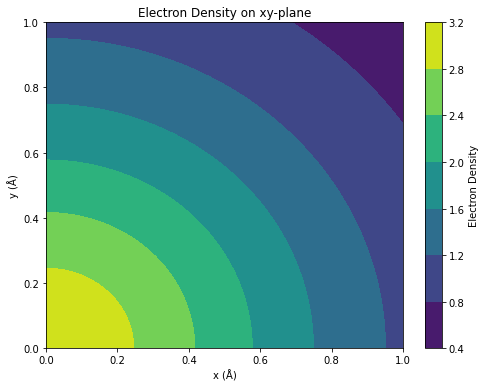

In [100]:
import matplotlib.pyplot as plt

# Create a meshgrid for plotting
X, Y = np.meshgrid(x_coords, y_coords)

# Plot the electron density using contour plot
plt.figure(figsize=(8, 6))
cp = plt.contourf(X, Y, electron_density, cmap='viridis')
plt.colorbar(cp, label='Electron Density')
plt.xlabel('x (Å)')
plt.ylabel('y (Å)')
plt.title('Electron Density on xy-plane')
plt.show()
